In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [35]:
df_all = pd.read_csv('./data/grouped/all_ccc_protocols.csv')

/var/folders/tj/3gxmkh714fb3xdsnffb_xyp80000gn/T/ipykernel_73104/1279922926.py:1: DtypeWarning: Columns (2,3,4,16,17,30,37,38,39,40,41,45,46,47,54,55,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv('./data/grouped/all_ccc_protocols.csv')


In [36]:
datasets = ["cctp", "ccip", "stargate_oft", "stargate_bus", "across"]

In [37]:
L1s = ["ethereum", "bnb", "avalanche"]
L2s = ["arbitrum", "optimism", "base", "scroll", "linea"]

# contains all blockchain pairs that have at least one cross-chain transaction
blockchain_pairs = []
for src_chain in df_all['src_blockchain'].unique():
    src_layer = "L1" if src_chain in L1s else ("L2" if src_chain in L2s else "sidechain")
    for dst_chain in df_all['dst_blockchain'].unique():
        dst_layer = "L1" if dst_chain in L1s else ("L2" if dst_chain in L2s else "sidechain")
        if df_all[(df_all['src_blockchain'] == src_chain) & (df_all['dst_blockchain'] == dst_chain)].shape[0] > 0:
            blockchain_pairs.append((src_chain, dst_chain, src_layer, dst_layer))

In [38]:
# count how many items are in every blockchain_type pair (l1-l1, l1-l2, l2-l1, l2-l2)
blockchain_pair_counts = {}
for src_layer, dst_layer in [["L1", "L1"], ["L1", "L2"], ["L2", "L1"], ["L2", "L2"]]:
    df = df_all[(df_all['src_blockchain_type'] == src_layer) & (df_all['dst_blockchain_type'] == dst_layer)]
    blockchain_pair_counts[(src_layer, dst_layer)] = {
        'count': df.shape[0],
        'percentage': df.shape[0] / df_all.shape[0] * 100
    }

blockchain_pair_counts

{('L1', 'L1'): {'count': 66906, 'percentage': 0.592835941031139},
 ('L1', 'L2'): {'count': 822995, 'percentage': 7.292335744012828},
 ('L2', 'L1'): {'count': 972365, 'percentage': 8.615862849381871},
 ('L2', 'L2'): {'count': 8526378, 'percentage': 75.54992564519178}}

## Table 1: Summary

In [39]:
def format_value_millions(value):
    if value >= 1_000_000:
        return f"{chr(92)}$ {value / 1_000_000:,.2f}M"
    else:
        return f"{chr(92)}$ {value:,.2f}"
    
def format_value_thousands(value):
    if value >= 1_000:
        return f"{chr(92)}$ {value / 1_000:,.2f}K"
    elif value >= 100:
        return f"{chr(92)}$ {value / 1000:.2f}K"
    else:
        return f"{chr(92)}$ {value:,.2f}"

In [41]:
results = {}

for bridge in ["cctp", "ccip", "stargate_oft", "stargate_bus", "across"]:
    bridge_data = df_all[df_all['bridge'] == bridge]
    num_txs = bridge_data.shape[0]
    unique_chains = bridge_data['src_blockchain'].nunique()
    value_transacted = bridge_data[['amount_usd', 'amount_received_ld_usd', 'output_amount_usd']].sum(axis=1).sum()
    Q1_value_transacted = bridge_data[['amount_usd', 'amount_received_ld_usd', 'output_amount_usd']].sum(axis=1).quantile(0.25)
    Q2_value_transacted = bridge_data[['amount_usd', 'amount_received_ld_usd', 'output_amount_usd']].sum(axis=1).median()
    Q3_value_transacted = bridge_data[['amount_usd', 'amount_received_ld_usd', 'output_amount_usd']].sum(axis=1).quantile(0.75)
    max_value_transacted = bridge_data[['amount_usd', 'amount_received_ld_usd', 'output_amount_usd']].sum(axis=1).max()
    unique_tokens = pd.concat([bridge_data['src_symbol'], bridge_data['dst_symbol']]).nunique()
    unique_depositors = pd.concat([bridge_data['depositor'], bridge_data['passenger']]).nunique()
    unique_recipients = pd.concat([bridge_data['recipient'], bridge_data['passenger']]).nunique()

    results[bridge] = {
        'num_txs': f"{num_txs:,}",
        'unique_chains': unique_chains,
        'value_transacted': format_value_millions(value_transacted),
        'Q1_value_transacted': format_value_millions(Q1_value_transacted),
        'Q2_value_transacted': format_value_millions(Q2_value_transacted),
        'Q3_value_transacted': format_value_millions(Q3_value_transacted),
        'max_value_transacted': format_value_millions(max_value_transacted),
        'unique_tokens': f"{unique_tokens:,}",
        'unique_depositors': f"{unique_depositors:,}",
        'unique_recipients': f"{unique_recipients:,}",
    }

results['total'] = {
    'num_txs': f"{df_all.shape[0]:,}",
    'unique_chains': df_all['src_blockchain'].nunique(),
    'value_transacted': format_value_millions(df_all[['amount_usd', 'amount_received_ld_usd', 'output_amount_usd']].sum(axis=1).sum()),
    'Q1_value_transacted': format_value_millions(df_all[['amount_usd', 'amount_received_ld_usd', 'output_amount_usd']].sum(axis=1).quantile(0.25)),
    'Q2_value_transacted': format_value_millions(df_all[['amount_usd', 'amount_received_ld_usd', 'output_amount_usd']].sum(axis=1).median()),
    'Q3_value_transacted': format_value_millions(df_all[['amount_usd', 'amount_received_ld_usd', 'output_amount_usd']].sum(axis=1).quantile(0.75)),
    'max_value_transacted': format_value_millions(df_all[['amount_usd', 'amount_received_ld_usd', 'output_amount_usd']].sum(axis=1).max()),
    'unique_tokens': f"{df_all['src_contract_address'].nunique():,}",
    'unique_depositors': f"{df_all['depositor'].nunique():,}",
    'unique_recipients': f"{df_all['recipient'].nunique():,}",
}

# Print results in LaTeX table format
print("\\begin{table}")
print("\\scriptsize")
print("\\begin{tabular}{l" + "r" * len(results) + "}")
print("\\toprule")
print(" & ".join([""] + [f"\\textbf{{{bridge.replace('_', chr(92) + '_')}}}" for bridge in results.keys()]) + " \\\\")
print("\\midrule")
for metric in results['cctp'].keys():
    row = [metric.replace('_', ' ').title()]
    for bridge in results.keys():
        value = results[bridge][metric]
        if isinstance(value, float):
            row.append(f"{value:.2f}")
        else:
            row.append(f"{value}")
    print(" & ".join(row) + " \\\\")
print("\\bottomrule")
print("\\end{tabular}")
print("\\caption{Summary statistics of Token Transfers for each bridge during the last 6 months of 2024 (Jun 1, 2024 to Dec 31, 2024)}")
print("\\end{table}")

\begin{table}
\scriptsize
\begin{tabular}{lrrrrrr}
\toprule
 & \textbf{cctp} & \textbf{ccip} & \textbf{stargate\_oft} & \textbf{stargate\_bus} & \textbf{across} & \textbf{total} \\
\midrule
Num Txs & 592,141 & 11,430 & 3,291,711 & 3,526,050 & 3,864,421 & 11,285,753 \\
Unique Chains & 6 & 9 & 9 & 9 & 7 & 10 \\
Value Transacted & \$ 8,567.50M & \$ 427.71M & \$ 10,413.35M & \$ 3,275.59M & \$ 5,513.69M & \$ 28,197.85M \\
Q1 Value Transacted & \$ 10.73 & \$ 350.99 & \$ 34.80 & \$ 18.62 & \$ 10.25 & \$ 17.37 \\
Q2 Value Transacted & \$ 150.39 & \$ 1,665.12 & \$ 154.02 & \$ 43.89 & \$ 51.95 & \$ 64.39 \\
Q3 Value Transacted & \$ 1,199.97 & \$ 19,971.28 & \$ 574.99 & \$ 252.11 & \$ 294.96 & \$ 383.44 \\
Max Value Transacted & \$ 1.00M & \$ 9.72M & \$ 287.39M & \$ 5.00M & \$ 3.57M & \$ 287.39M \\
Unique Tokens & 1 & 71 & 5 & 4 & 104 & 225 \\
Unique Depositors & 16,291 & 1,749 & 215,706 & 722,251 & 737,176 & 916,405 \\
Unique Recipients & 121,924 & 2,228 & 592,992 & 722,251 & 1,079,408 & 1,765,8

## Figure 5: Daily Cross-Chain Transaction Count

In [55]:
time_interval_days = 1

df_all.loc[df_all['bridge'] != 'stargate_bus', 'day_rounded'] = (pd.to_datetime(df_all['src_timestamp'], unit='s').dt.day // time_interval_days) * time_interval_days
df_all.loc[df_all['bridge'] == 'stargate_bus', 'day_rounded'] = (pd.to_datetime(df_all['user_timestamp'], unit='s').dt.day // time_interval_days) * time_interval_days

df_all['day_rounded'] = df_all['day_rounded'].astype(int)

df_all['datetime_group'] = pd.to_datetime(df_all['src_timestamp'], unit='s').dt.strftime('%Y-%m-%d %H:00')

# Define the possible column names
amount_columns = ['amount_usd', 'amount_received_ld_usd', 'output_amount_usd']

# Find the first column that exists in df_all
amount_col = next((col for col in amount_columns if col in df_all.columns), None)

if amount_col:
    df_grouped = df_all.groupby(['bridge', 'datetime_group']).agg(
        count=(amount_col, 'size'),  # Count transactions per group
        grouped_usd_value=(amount_col, 'sum')  # Sum the selected column
    ).reset_index()
else:
    print("No valid amount column found in df_all")
    df_grouped = None  # Or handle this case differently



# Create a new column combining year, month, day, and rounded hour
df_all.loc[df_all['bridge']!= 'stargate_bus', 'datetime_group'] = pd.to_datetime(df_all['src_timestamp'], unit='s').dt.strftime('%Y-%m-') + df_all['day_rounded'].astype(str).str.zfill(2) + " 00:00"
df_all.loc[df_all['bridge'] == 'stargate_bus', 'datetime_group'] = pd.to_datetime(df_all['user_timestamp'], unit='s').dt.strftime('%Y-%m-') + df_all['day_rounded'].astype(str).str.zfill(2) + " 00:00"

# limit the data from 1 jun 2024 to 31 dec 2024
df_grouped = df_grouped[(df_grouped['datetime_group'] >= '2024-06-01') & (df_grouped['datetime_group'] <= '2024-12-31')]

## Latencies and Costs Tables

In [ ]:
def get_costs_blockchain_pairs(bridge, src_chain, dst_chain):
    df = df_all[(df_all['bridge'] == bridge) & (df_all['src_blockchain'] == src_chain) & (df_all['dst_blockchain'] == dst_chain)]
    operator_costs = df_all[(df_all['bridge'] == bridge) & (df_all['src_blockchain'] == src_chain) & (df_all['dst_blockchain'] == dst_chain)]['operator_cost']

    user_costs = df['user_cost']

    if user_costs.shape[0] == 0:
        return None
    
    if operator_costs.shape[0] == 0:
        return None
    
    return {
        'user_costs': {
            'total_value_transferred': df[['amount_usd', 'amount_received_ld_usd', 'output_amount_usd']].median().sum(),
            'count': user_costs.shape[0],
            'Q1': user_costs.quantile(0.25),
            'Q2': user_costs.quantile(0.5),
            'Q3': user_costs.quantile(0.75),
            'IQR': user_costs.quantile(0.75) - user_costs.quantile(0.25),
        },
        'operator_costs': {
            'count': operator_costs.shape[0],
            'Q1': operator_costs.quantile(0.25),
            'Q2': operator_costs.quantile(0.5),
            'Q3': operator_costs.quantile(0.75),
            'IQR': operator_costs.quantile(0.75) - operator_costs.quantile(0.25),
        }
    }

# make a function that returns the user and operator costs (count of datapoints, mean, median, std) for a specific blockchain layer pair
def get_costs_blockchain_layer_pairs(bridge, src_layer, dst_layer):
    df = df_all[(df_all['bridge'] == bridge) & (df_all['src_blockchain_type'] == src_layer) & (df_all['dst_blockchain_type'] == dst_layer)]
    operator_costs = df_all[(df_all['bridge'] == bridge) & (df_all['src_blockchain_type'] == src_layer) & (df_all['dst_blockchain_type'] == dst_layer)]['operator_cost']

    user_costs = df['user_cost']

    if user_costs.shape[0] == 0:
        return None
    
    if operator_costs.shape[0] == 0:
        return None

    return {
        'user_costs': {
            'total_value_transferred': df[['amount_usd', 'amount_received_ld_usd', 'output_amount_usd']].median().sum(),
            'count': user_costs.shape[0],
            'Q1': user_costs.quantile(0.25),
            'Q2': user_costs.quantile(0.5),
            'Q3': user_costs.quantile(0.75),
            'IQR': user_costs.quantile(0.75) - user_costs.quantile(0.25),
        },
        'operator_costs': {
            'count': operator_costs.shape[0],
            'Q1': operator_costs.quantile(0.25),
            'Q2': operator_costs.quantile(0.5),
            'Q3': operator_costs.quantile(0.75),
            'IQR': operator_costs.quantile(0.75) - operator_costs.quantile(0.25),
        }
    }

In [ ]:
def print_analysis_per_blockchain_pair(pair1, pair2, datasets, hue_metric, plot_costs=False, plot_latencies=False):
    pair1_first_letter_1 = pair1[0][0].upper()
    pair1_first_letter_2 = pair1[1][0].upper()
    pair2_first_letter_1 = pair2[0][0].upper()
    pair2_first_letter_2 = pair2[1][0].upper()

    print("\\begin{table}")
    print("\\rowcolors{2}{gray!10}{white}")
    print("\\tiny")
    print("\\begin{tabular}{l" + "c" * (len(datasets))*2+ "}")
    print("\\toprule")
    print(" & ".join([""] + [f"\multicolumn{{2}}{{c}}{{\\textbf{{{bridge.replace('_', chr(92) + '_')}}}}}"  for bridge in datasets]) + " \\\\")
    print("\\cmidrule(r){2-3} \\cmidrule(rl){4-5} \\cmidrule(rl){6-7} \\cmidrule(l){8-9}")
    print(" & ".join([""] + [f"{pair1_first_letter_1} ${chr(92)}rightarrow$ {pair1_first_letter_2}", f"{pair2_first_letter_1} ${chr(92)}rightarrow$ {pair2_first_letter_2}"] * (len(datasets))) + " \\\\")
    print("\\hline")


    all_data = {}

    for bridge in datasets:

        latency_1 = get_latency_blockchain_pairs(bridge, pair1[0], pair1[1])
        latency_2 = get_latency_blockchain_pairs(bridge, pair2[0], pair2[1])

        cost_1 = get_costs_blockchain_pairs(bridge, pair1[0], pair1[1])
        cost_2 = get_costs_blockchain_pairs(bridge, pair2[0], pair2[1])

        all_data[bridge] = {
            'latency_1': latency_1,
            'latency_2': latency_2,
            'cost_1': cost_1,
            'cost_2': cost_2
        }

    # print size of CCTXs one time
    row = ["Size CCTXs"]
    for bridge in datasets:
        if all_data[bridge]['latency_2'] is None:
            row.append(f"& {all_data[bridge]['latency_1']['count']} & ")
        else:
            row.append(f"& {all_data[bridge]['latency_1']['count']} & {all_data[bridge]['latency_2']['count']}")
    print(" ".join(row) + " \\\\")

    # print value transferred one time
    row = ["Value Trsf (\$)"]
    for bridge in datasets:
        if all_data[bridge]['latency_2'] is None:
            row.append(f"& {format_value_millions(all_data[bridge]['latency_1']['total_value_transferred'])} & ")
        else:
            row.append(f"& {format_value_millions(all_data[bridge]['latency_1']['total_value_transferred'])} & {format_value_millions(all_data[bridge]['latency_2']['total_value_transferred'])}")
    print(" ".join(row) + " \\\\")

    metrics = ["Q1", "Q2", "Q3", "IQR"]

    for m in ["latency", "cost"]:
        print("\\hline")
        print(f"\multicolumn{{9}}{{c}}{{\\textbf{{{m.capitalize()}}}}} \\\\")
        for metric in metrics:
            row = [f"{metric}"]
            for bridge in datasets:

                if m == "cost":
                    cost_1 = all_data[bridge]['cost_1']
                    cost_2 = all_data[bridge]['cost_2']
                    
                    if metric == "Q2": # put the median in bold
                        if cost_2 is None:
                            row.append(f"& \cellcolor{{blue!25}}{cost_1['user_costs'][metric]:,.2f} & ")
                        else:
                            row.append(f"& \cellcolor{{blue!25}}{cost_1['user_costs'][metric]:,.2f} & \cellcolor{{blue!25}}{cost_2['user_costs'][metric]:,.2f}")
                    else:
                        if cost_2 is None:
                            row.append(f"& {cost_1['user_costs'][metric]:,.2f} & ")
                        else:
                            row.append(f"& {cost_1['user_costs'][metric]:,.2f} & {cost_2['user_costs'][metric]:,.2f}")
                else:
                    latency_1 = all_data[bridge]['latency_1']
                    latency_2 = all_data[bridge]['latency_2']

                    if metric == "Q2": # put the median in blue
                        if latency_2 is None:
                            row.append(f"& \cellcolor{{blue!25}}{latency_1[metric]:,.2f} & ")
                        else:
                            row.append(f"& \cellcolor{{blue!25}}{latency_1[metric]:,.2f} & \cellcolor{{blue!25}}{latency_2[metric]:,.2f}")
                    else:
                        if latency_2 is None:
                            row.append(f"& {latency_1[metric]:,.2f} & ")
                        else:
                            row.append(f"& {latency_1[metric]:,.2f} & {latency_2[metric]:,.2f}")

            print(" ".join(row) + " \\\\")

    
    print("\\end{tabular}")
    print("\\caption{Count, median, and standard deviation of the cost for all cross-chain transactions across multiple cross-chain protocols between X 2024 and 1 Jan 2025. Protocols included: CCTP, CCIP, Stargate (OFT), Stargate (Bus), Across.}")
    print("\\end{table}")

    df_filtered = df_all[(df_all['src_blockchain'] == pair1[0]) & (df_all['dst_blockchain'] == pair1[1]) & (df_all['bridge'].isin(datasets)) | (df_all['src_blockchain'] == pair2[0]) & (df_all['dst_blockchain'] == pair2[1]) & (df_all['bridge'].isin(datasets))]
    
    if plot_costs:

        plt.figure(figsize=(10, 12))
        for i, bridge in enumerate(datasets):

            plt.subplot(len(datasets), 1, i + 1)
            bridge_data = df_filtered[df_filtered['bridge'] == bridge]

            if bridge == "stargate_bus":
                sns.scatterplot(data=bridge_data, x='user_cost', y='amount_received_ld_usd', hue=hue_metric)
            elif bridge == "across":
                sns.scatterplot(data=bridge_data, x='user_cost', y='output_amount_usd', hue=hue_metric)
            else:
                sns.scatterplot(data=bridge_data, x='user_cost', y='amount_usd', hue=hue_metric)

            plt.xlabel('CCTX User Cost (USD)')
            plt.ylabel('Value Trsf (USD)')
            plt.title(f'Ethereum <-> Avalanche: {bridge}')
            plt.yscale('symlog')
            plt.xscale('symlog')
            plt.ylim(0, 10_000_000)
            plt.xlim(-50, 350)
        plt.tight_layout()
        plt.show()

    if plot_latencies:
        plt.figure(figsize=(15, 20))
        for i, bridge in enumerate(datasets):
            plt.subplot(len(datasets), 1, i + 1)
            bridge_data = df_filtered[df_filtered['bridge'] == bridge]

            if bridge == "across":
                sns.scatterplot(data=bridge_data, x='latency', y='output_amount_usd', hue='src_blockchain')
            elif bridge == "stargate_bus":
                sns.scatterplot(data=bridge_data, x='latency', y='amount_received_ld_usd', hue='src_blockchain')
            else:
                sns.scatterplot(data=bridge_data, x='latency', y='amount_usd', hue='src_blockchain')

            plt.xlabel('CCTX Latency (s)')
            plt.ylabel('Value Trsf (USD)')
            plt.title(f'Base <-> Arbitrum: {bridge}')
            plt.xlim(-1_000, 10_000_000)
            plt.ylim(0.000001, 10_000_000)
            plt.xscale('symlog')
            plt.yscale('log')
        plt.tight_layout()
        plt.show()



\begin{table}
\rowcolors{2}{gray!10}{white}
\tiny
\begin{tabular}{lcccccccc}
\toprule
 & \multicolumn{2}{c}{\textbf{cctp}} & \multicolumn{2}{c}{\textbf{ccip}} & \multicolumn{2}{c}{\textbf{stargate\_oft}} & \multicolumn{2}{c}{\textbf{stargate\_bus}} \\
\cmidrule(r){2-3} \cmidrule(rl){4-5} \cmidrule(rl){6-7} \cmidrule(l){8-9}
 & E $\rightarrow$ A & A $\rightarrow$ E & E $\rightarrow$ A & A $\rightarrow$ E & E $\rightarrow$ A & A $\rightarrow$ E & E $\rightarrow$ A & A $\rightarrow$ E \\
\hline
Size CCTXs & 2211 & 4126 & 113 & 71 & 1676 & 1408 & 374 & 1085 \\
Value Trsf (\$) & \$ 139.80M & \$ 148.72M & \$ 12.12M & \$ 8.98M & \$ 14.57M & \$ 26.34M & \$ 3.66M & \$ 5.82M \\
\hline
\multicolumn{9}{c}{\textbf{Latency}} \\
Q1 & 926.00 & 32.00 & 915.00 & 103.50 & 209.00 & 132.00 & 452.00 & 352.00 \\
Q2 & \cellcolor{blue!25}1,044.00 & \cellcolor{blue!25}57.00 & \cellcolor{blue!25}983.00 & \cellcolor{blue!25}138.00 & \cellcolor{blue!25}212.00 & \cellcolor{blue!25}139.00 & \cellcolor{blue!25}464.00

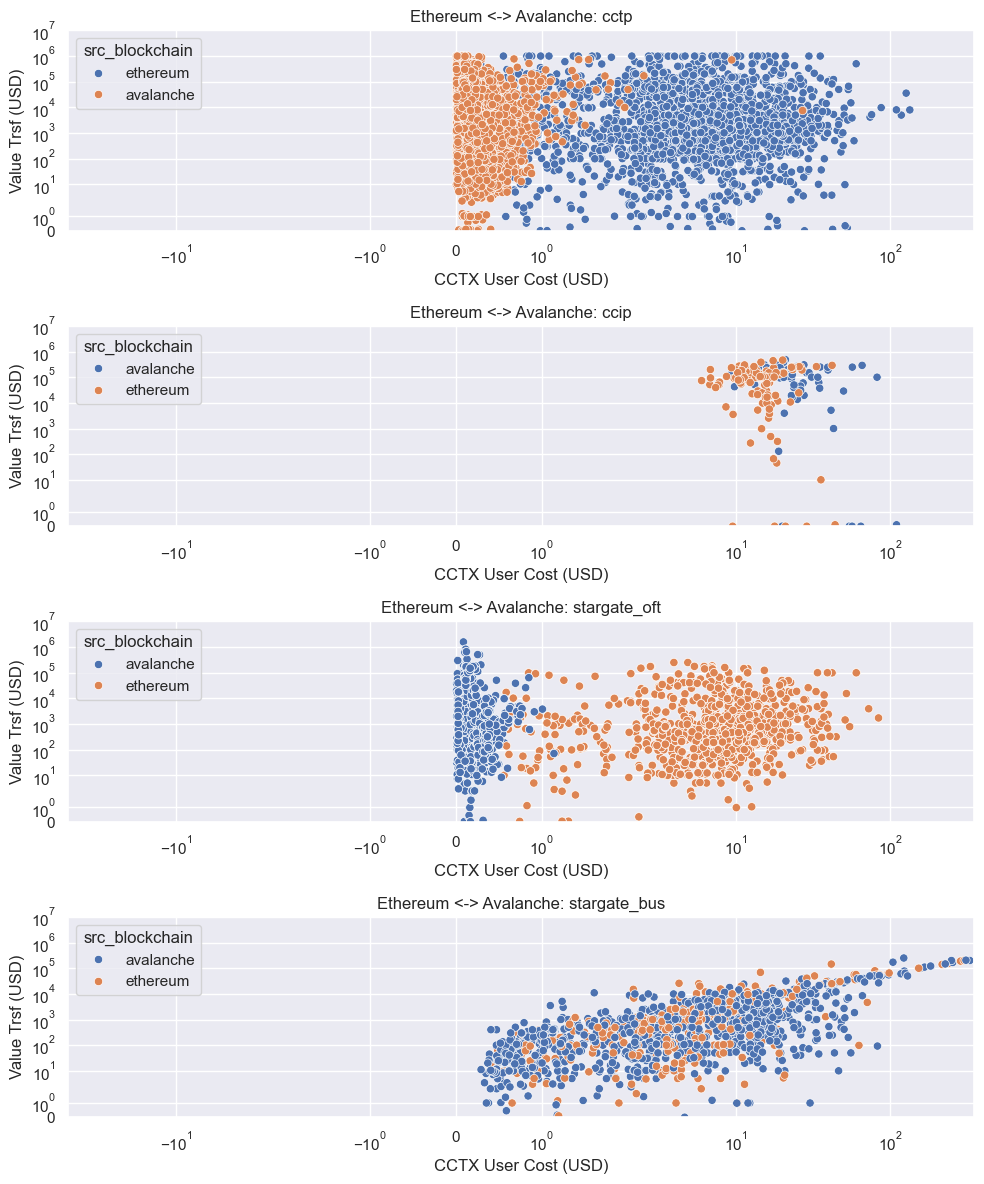

In [43]:
print_analysis_per_blockchain_pair(["ethereum", "avalanche"], ["avalanche", "ethereum"], ["cctp", "ccip", "stargate_oft", "stargate_bus"], 'src_blockchain', True, False)

In [44]:
print_analysis_per_blockchain_pair(["ethereum", "base"], ["avalanche", "base"], ["cctp", "ccip", "stargate_oft", "stargate_bus", "across"], 'src_blockchain')

\begin{table}
\rowcolors{2}{gray!10}{white}
\tiny
\begin{tabular}{lcccccccccc}
\toprule
 & \multicolumn{2}{c}{\textbf{cctp}} & \multicolumn{2}{c}{\textbf{ccip}} & \multicolumn{2}{c}{\textbf{stargate\_oft}} & \multicolumn{2}{c}{\textbf{stargate\_bus}} & \multicolumn{2}{c}{\textbf{across}} \\
\cmidrule(r){2-3} \cmidrule(rl){4-5} \cmidrule(rl){6-7} \cmidrule(l){8-9}
 & E $\rightarrow$ B & A $\rightarrow$ B & E $\rightarrow$ B & A $\rightarrow$ B & E $\rightarrow$ B & A $\rightarrow$ B & E $\rightarrow$ B & A $\rightarrow$ B & E $\rightarrow$ B & A $\rightarrow$ B \\
\hline
Size CCTXs & 23882 & 14238 & 461 & 126 & 27002 & 8870 & 16476 & 3349 & 279910 &  \\
Value Trsf (\$) & \$ 837.29M & \$ 203.42M & \$ 8.51M & \$ 10.35M & \$ 328.28M & \$ 8.59M & \$ 80.05M & \$ 1.51M & \$ 531.03M &  \\
\hline
\multicolumn{9}{c}{\textbf{Latency}} \\
Q1 & 936.00 & 22.00 & 964.00 & 61.25 & 210.00 & 52.00 & 436.00 & 247.00 & 16.00 &  \\
Q2 & \cellcolor{blue!25}1,064.00 & \cellcolor{blue!25}63.00 & \cellcolor{bl

In [45]:
print_analysis_per_blockchain_pair(["base", "ethereum"], ["base", "avalanche"], ["cctp", "ccip", "stargate_oft", "stargate_bus", "across"], 'dst_blockchain')

\begin{table}
\rowcolors{2}{gray!10}{white}
\tiny
\begin{tabular}{lcccccccccc}
\toprule
 & \multicolumn{2}{c}{\textbf{cctp}} & \multicolumn{2}{c}{\textbf{ccip}} & \multicolumn{2}{c}{\textbf{stargate\_oft}} & \multicolumn{2}{c}{\textbf{stargate\_bus}} & \multicolumn{2}{c}{\textbf{across}} \\
\cmidrule(r){2-3} \cmidrule(rl){4-5} \cmidrule(rl){6-7} \cmidrule(l){8-9}
 & B $\rightarrow$ E & B $\rightarrow$ A & B $\rightarrow$ E & B $\rightarrow$ A & B $\rightarrow$ E & B $\rightarrow$ A & B $\rightarrow$ E & B $\rightarrow$ A & B $\rightarrow$ E & B $\rightarrow$ A \\
\hline
Size CCTXs & 22272 & 8598 & 353 & 308 & 14987 & 8046 & 56950 & 2326 & 140641 &  \\
Value Trsf (\$) & \$ 616.46M & \$ 124.99M & \$ 8.54M & \$ 17.09M & \$ 432.39M & \$ 13.09M & \$ 84.22M & \$ 2.56M & \$ 669.63M &  \\
\hline
\multicolumn{9}{c}{\textbf{Latency}} \\
Q1 & 1,198.00 & 1,209.00 & 1,334.00 & 1,257.75 & 126.00 & 46.00 & 228.00 & 241.00 & 4.00 &  \\
Q2 & \cellcolor{blue!25}1,328.00 & \cellcolor{blue!25}1,326.00 & \

\begin{table}
\rowcolors{2}{gray!10}{white}
\tiny
\begin{tabular}{lcccccccccc}
\toprule
 & \multicolumn{2}{c}{\textbf{cctp}} & \multicolumn{2}{c}{\textbf{ccip}} & \multicolumn{2}{c}{\textbf{stargate\_oft}} & \multicolumn{2}{c}{\textbf{stargate\_bus}} & \multicolumn{2}{c}{\textbf{across}} \\
\cmidrule(r){2-3} \cmidrule(rl){4-5} \cmidrule(rl){6-7} \cmidrule(l){8-9}
 & B $\rightarrow$ A & A $\rightarrow$ B & B $\rightarrow$ A & A $\rightarrow$ B & B $\rightarrow$ A & A $\rightarrow$ B & B $\rightarrow$ A & A $\rightarrow$ B & B $\rightarrow$ A & A $\rightarrow$ B \\
\hline
Size CCTXs & 71532 & 76498 & 379 & 450 & 250438 & 576116 & 198497 & 208847 & 278554 & 439916 \\
Value Trsf (\$) & \$ 311.32M & \$ 288.61M & \$ 4.88M & \$ 5.87M & \$ 612.03M & \$ 844.36M & \$ 174.73M & \$ 170.80M & \$ 203.03M & \$ 239.04M \\
\hline
\multicolumn{9}{c}{\textbf{Latency}} \\
Q1 & 1,228.00 & 1,013.00 & 1,263.50 & 1,029.00 & 29.00 & 31.00 & 61.00 & 57.00 & 1.00 & 2.00 \\
Q2 & \cellcolor{blue!25}1,347.00 & \cel

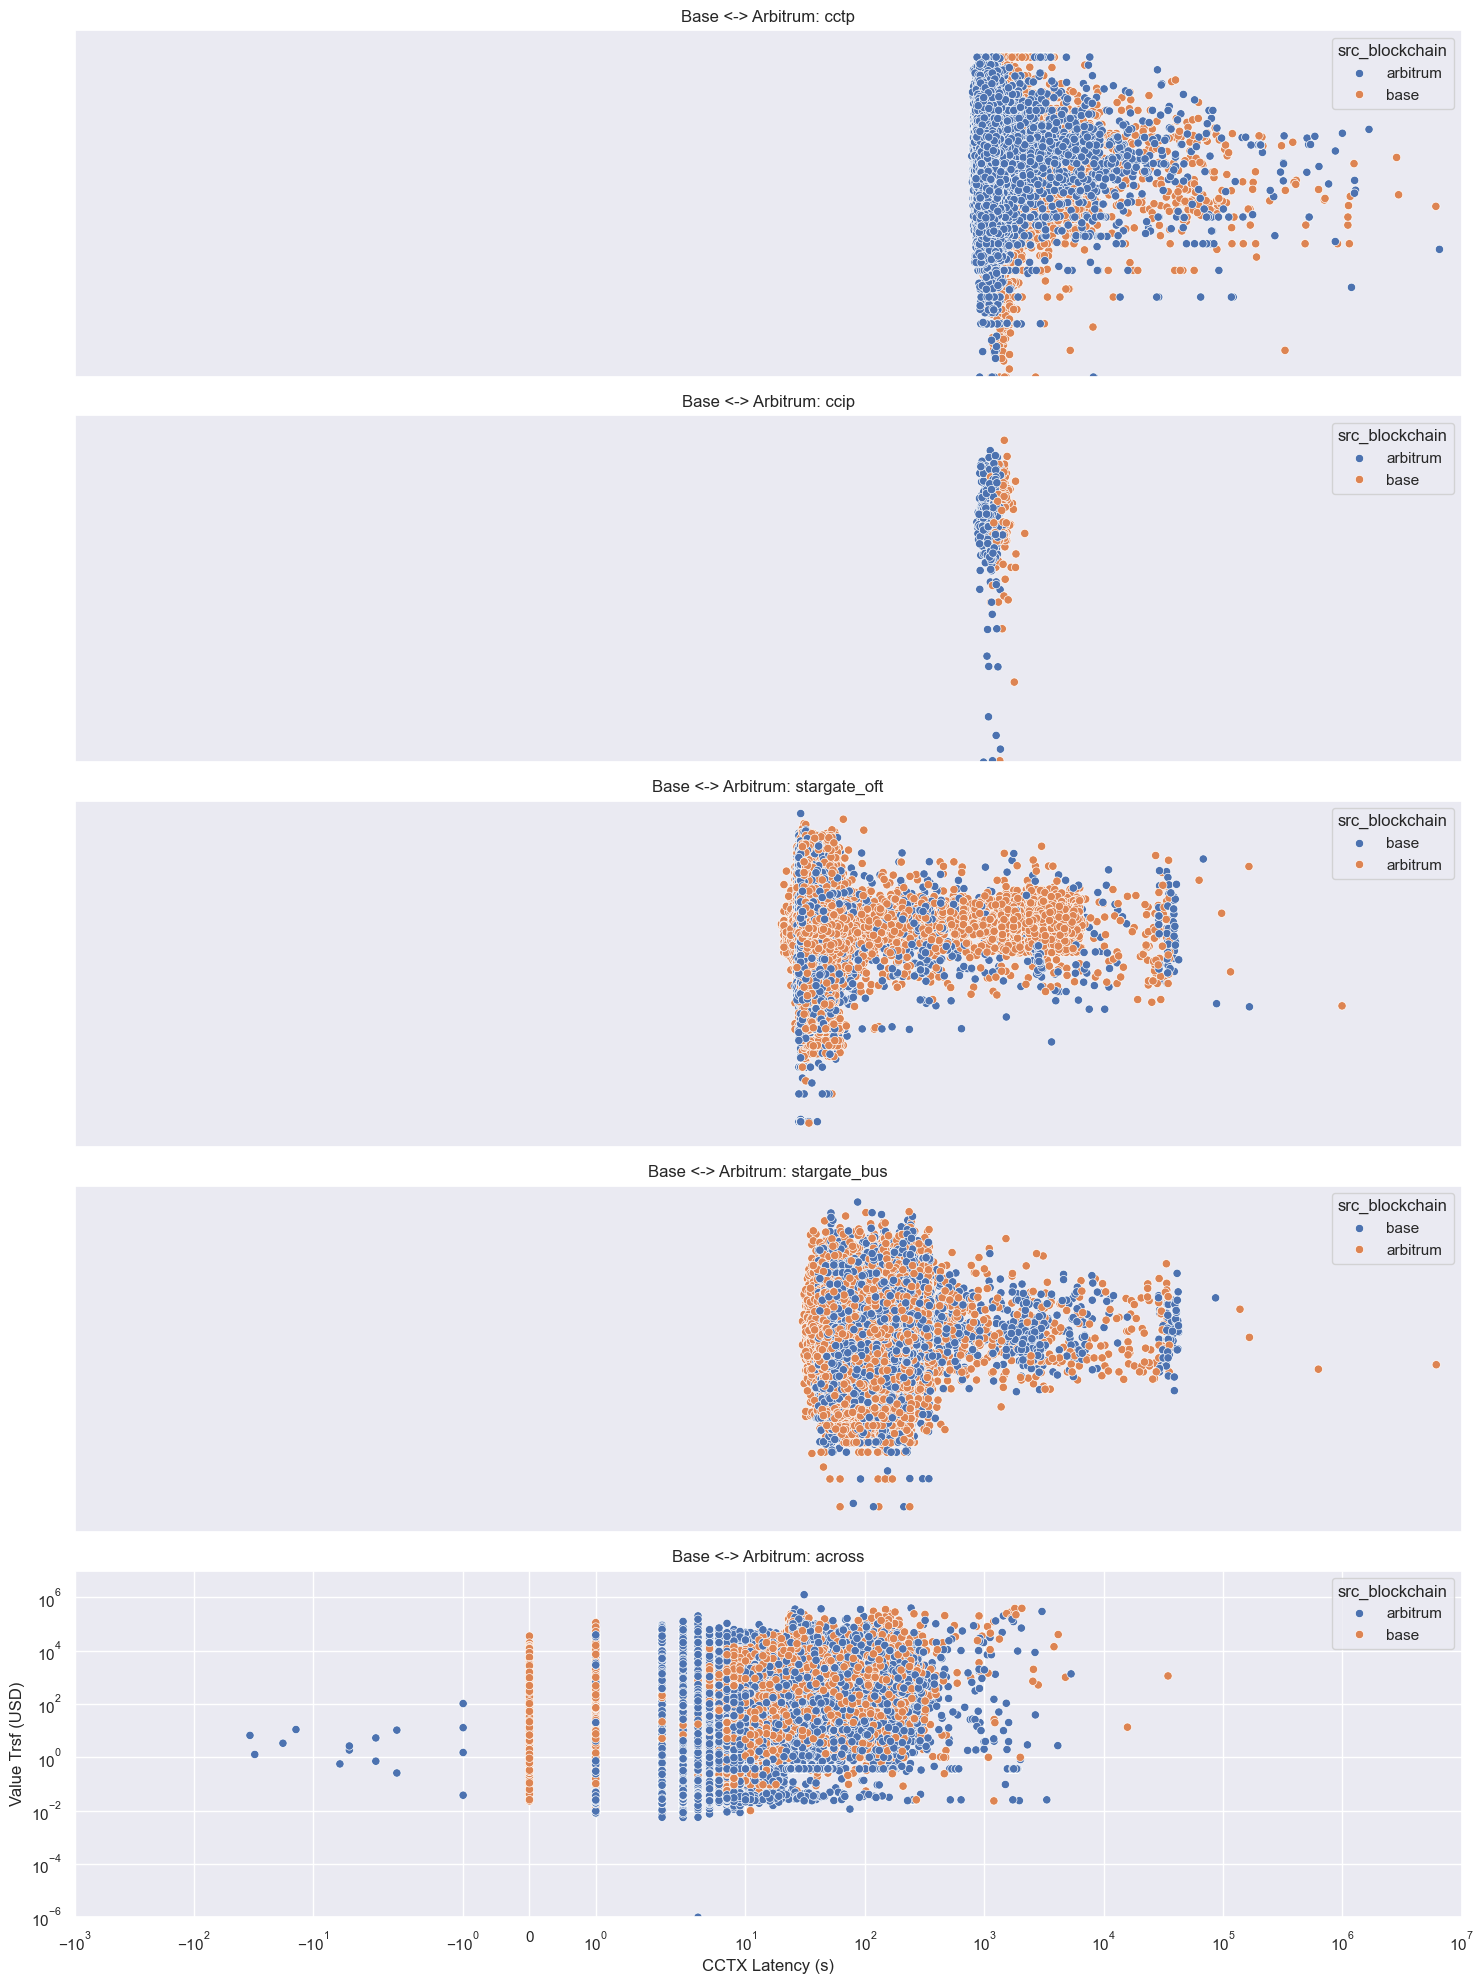

In [46]:
print_analysis_per_blockchain_pair(["base", "arbitrum"], ["arbitrum", "base"], ["cctp", "ccip", "stargate_oft", "stargate_bus", "across"], 'src_blockchain', False, True)

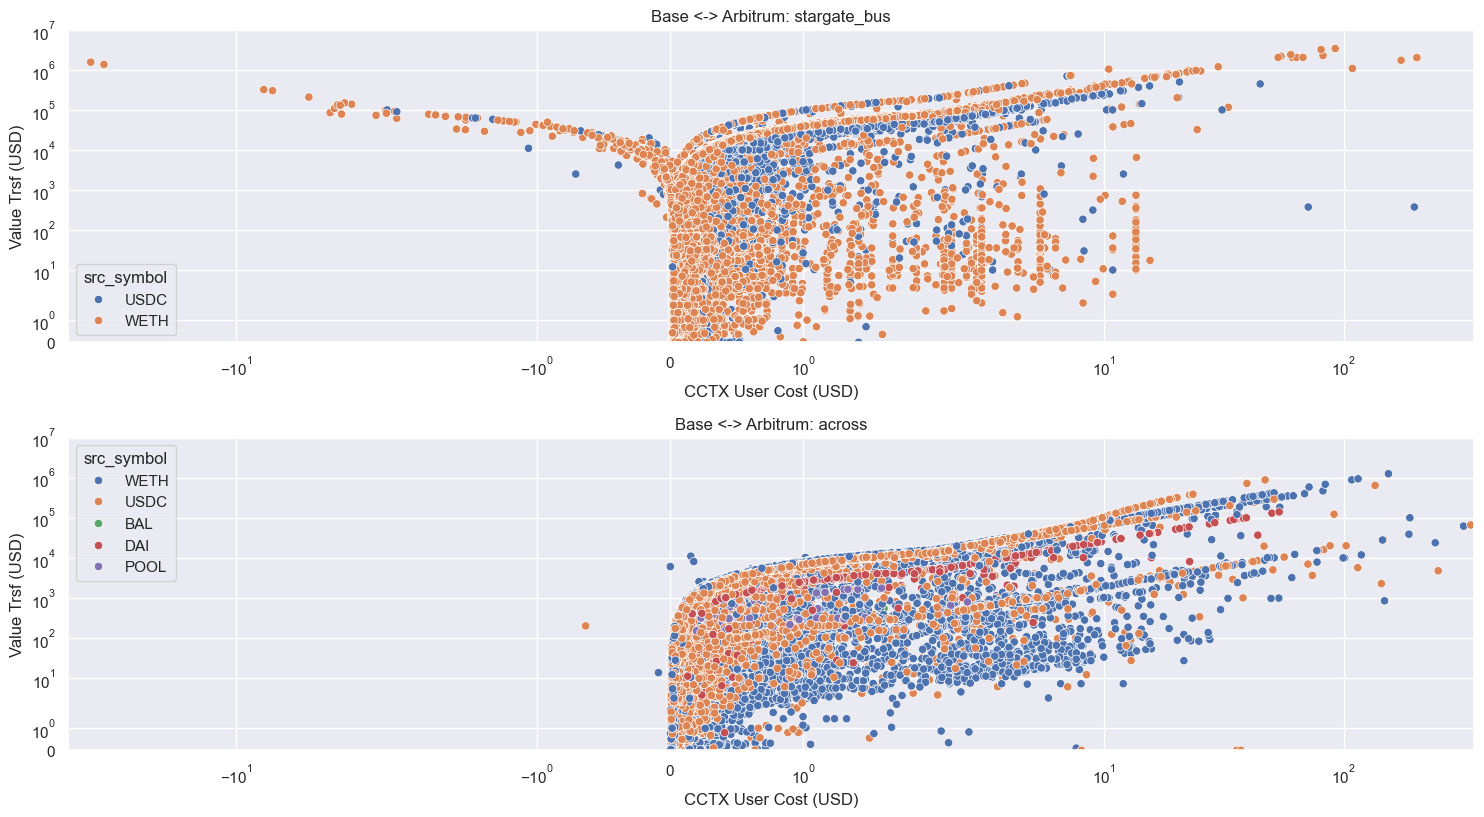

In [47]:
df_base_and_arb = df_all[(df_all['src_blockchain'].isin(['base', 'arbitrum'])) & (df_all['dst_blockchain'].isin(['base', 'arbitrum'])) & (df_all['bridge'].isin(datasets))]

plt.figure(figsize=(15, 20))
for i, bridge in enumerate(["stargate_bus", "across"]):
    plt.subplot(len(datasets), 1, i + 1)
    bridge_data = df_base_and_arb[df_base_and_arb['bridge'] == bridge]

    if bridge == "across":
        sns.scatterplot(data=bridge_data, x='user_cost', y='output_amount_usd', hue="src_symbol")
    elif bridge == "stargate_bus":
        sns.scatterplot(data=bridge_data, x='user_cost', y='amount_received_ld_usd', hue="src_symbol")

    plt.xlabel('CCTX User Cost (USD)')
    plt.ylabel('Value Trsf (USD)')
    plt.title(f'Base <-> Arbitrum: {bridge}')
    # log scale for both positive and negative values
    plt.yscale('symlog')
    plt.xscale('symlog')
    plt.ylim(0, 10_000_000)
    plt.xlim(-50, 350)
plt.tight_layout()
plt.show()


## Stargate Bus Fare & Fee vs. Ethereum Gas Price

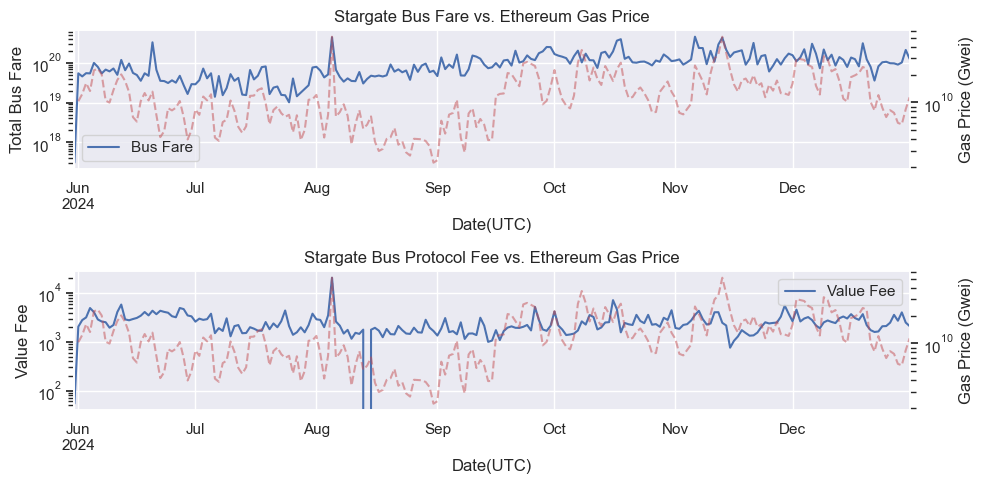

0.6640860791428839
0.4014491460459123


In [48]:
import matplotlib.pyplot as plt

df = pd.read_csv('./data/stargate_bus.csv')

# Read gas prices data
gas_prices = pd.read_csv('./data/gas_price_raw.csv')
gas_prices["Date(UTC)"] = pd.to_datetime(gas_prices["Date(UTC)"])

# Prepare the data
df['date'] = pd.to_datetime(df['user_timestamp'], unit='s')
df['day'] = df['date'].dt.date

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

# First subplot: Total bus fare per day
grouped_per_day_fare = df.groupby('day')['bus_fare'].sum()
grouped_per_day_fare.plot(kind='line', ax=axes[0])
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Bus Fare')
axes[0].set_yscale('log')
axes[0].set_title('Stargate Bus Fare vs. Ethereum Gas Price')
axes[0].tick_params(axis='x', rotation=90)

# Plot gas prices on the first subplot
gas_prices.set_index('Date(UTC)')['Value (Wei)'].plot(secondary_y=True, ax=axes[0], color='r', linestyle='--', alpha=0.5)
axes[0].right_ax.set_ylabel('Gas Price (Gwei)')
axes[0].right_ax.set_yscale('log')
axes[0].legend(['Bus Fare', 'Gas Price'])

# Second subplot: Value fee per day
df['value_fee'] = df['amount_sent_ld_usd'] - df['amount_received_ld_usd']
grouped_per_day_value_fee = df.groupby('day')['value_fee'].sum()
grouped_per_day_value_fee.plot(kind='line', ax=axes[1])
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value Fee')
axes[1].set_yscale('log')
axes[1].set_title('Stargate Bus Protocol Fee vs. Ethereum Gas Price')
axes[1].tick_params(axis='x', rotation=90)

# Plot gas prices on the second subplot
gas_prices.set_index('Date(UTC)')['Value (Wei)'].plot(secondary_y=True, ax=axes[1], color='r', linestyle='--', alpha=0.5)
axes[1].right_ax.set_ylabel('Gas Price (Gwei)')
axes[1].right_ax.set_yscale('log')
axes[1].legend(['Value Fee', 'Gas Price'])

plt.tight_layout()
plt.show()

# Calculate and print correlations
grouped_per_day_fare = grouped_per_day_fare.reset_index()
grouped_per_day_fare['gas_price'] = grouped_per_day_fare['day'].map(gas_prices.set_index('Date(UTC)')['Value (Wei)'])
print(grouped_per_day_fare['bus_fare'].corr(grouped_per_day_fare['gas_price']))

grouped_per_day_value_fee = grouped_per_day_value_fee.reset_index()
grouped_per_day_value_fee['gas_price'] = grouped_per_day_value_fee['day'].map(gas_prices.set_index('Date(UTC)')['Value (Wei)'])
print(grouped_per_day_value_fee['value_fee'].corr(grouped_per_day_value_fee['gas_price']))


## Across Fee vs. Ethereum Gas Price

np.float64(0.572383408386684)

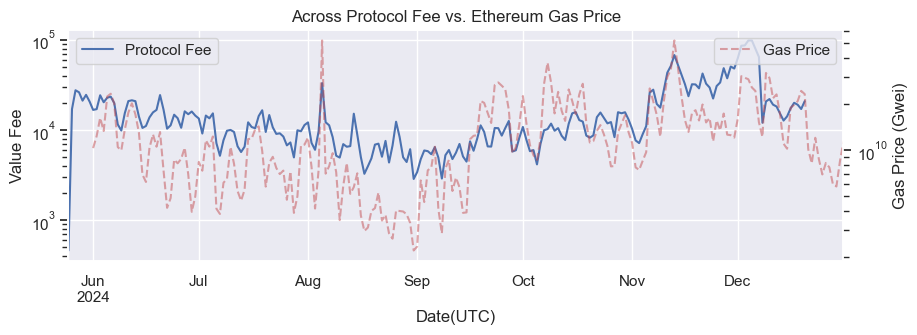

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

across_df = pd.read_csv('./data/across.csv')

# agg all fares based on day and plot day vs total_fare
gas_prices = pd.read_csv('./data/gas_price_raw.csv')
gas_prices["Date(UTC)"] = pd.to_datetime(gas_prices["Date(UTC)"])

across_df['value_fee'] = across_df['input_amount_usd'] - across_df['output_amount_usd']
across_df['date'] = pd.to_datetime(across_df['src_timestamp'], unit='s')
across_df['day'] = across_df['date'].dt.date
grouped_per_day = across_df.groupby('day')['value_fee'].sum()
grouped_per_day.plot(kind='line')

plt.xlabel('Date')
plt.ylabel('Value Fee')
plt.xticks(rotation=90)
plt.yscale('log')
plt.legend(['Protocol Fee'])

# plot across_df day vs. value_fee and day vs. gas_price
gas_prices.set_index('Date(UTC)')['Value (Wei)'].plot(secondary_y=True, ax=plt.gca(), color='r', linestyle='--', alpha=0.5, figsize=(10, 3))
plt.ylabel('Gas Price (Gwei)')
plt.title('Across Protocol Fee vs. Ethereum Gas Price')
plt.yscale('log')
plt.legend(['Gas Price'])
plt.xticks(rotation=90)


# add a new column gas_price to grouped_per_day where gas_price Date(UTC) matches day
grouped_per_day = grouped_per_day.reset_index()
grouped_per_day['gas_price'] = grouped_per_day['day'].map(gas_prices.set_index('Date(UTC)')['Value (Wei)'])

grouped_per_day

# write correlation between value_fee and gas_price
grouped_per_day.dropna(inplace=True)
grouped_per_day['value_fee'].corr(grouped_per_day['gas_price'])

## CCIP vs. Ethereum Gas Price

In [50]:
def plot_fee_token_amount_vs_date(df, blockchain, token):
    token_fee = df[(df["src_blockchain"] == blockchain) & (df["fee_token"] == token)]

    # plot fee_token_amount in token_fee with dates based on src_timestmap (unix ts)

    import matplotlib.pyplot as plt
    import seaborn as sns

    # add a date column based on src_timestamp
    token_fee['date'] = pd.to_datetime(token_fee['src_timestamp'], unit='s')

    # plot fee_token_amount_usd vs date
    plt.figure(figsize=(10, 3))
    sns.scatterplot(data=token_fee, x='date', y='fee_token_amount', hue='dst_blockchain')
    plt.xlabel('Date')
    plt.ylabel('fee_token_amount')
    plt.yscale('log')
    plt.title(f'fee_token_amount vs Date for token {token}')
    plt.xticks()
    plt.show()

/var/folders/tj/3gxmkh714fb3xdsnffb_xyp80000gn/T/ipykernel_73104/2496215806.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_fee['date'] = pd.to_datetime(token_fee['src_timestamp'], unit='s')


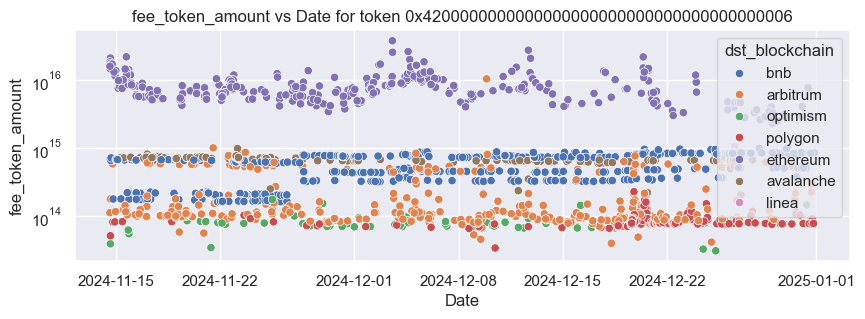

In [51]:
ccip_df = pd.read_csv('./data/ccip.csv')

plot_fee_token_amount_vs_date(ccip_df, 'base', "0x4200000000000000000000000000000000000006")

### Global Latencies

In [52]:
def get_latency_blockchain_pairs(bridge, src_chain, dst_chain):
    df = df_all[(df_all['bridge'] == bridge) & (df_all['src_blockchain'] == src_chain) & (df_all['dst_blockchain'] == dst_chain)]

    latency = df['latency']
    if latency.shape[0] == 0:
        return None
    
    return {
        'total_value_transferred': df[['amount_usd', 'amount_received_ld_usd', 'output_amount_usd']].sum().sum(),
        'count': latency.shape[0],
        'Q1': latency.quantile(0.25),
        'Q2': latency.quantile(0.5),
        'Q3': latency.quantile(0.75),
        'IQR': latency.quantile(0.75) - latency.quantile(0.25),
    }

# make a function that returns the user and operator costs (count of datapoints, mean, median, std) for a specific blockchain layer pair
def get_latency_blockchain_layer_pairs(bridge, src_layer, dst_layer):
    df = df_all[(df_all['bridge'] == bridge) & (df_all['src_blockchain_type'] == src_layer) & (df_all['dst_blockchain_type'] == dst_layer)]

    latency = df['latency']

    if latency.shape[0] == 0:
        return None

    return {
        'total_value_transferred': df[['amount_usd', 'amount_received_ld_usd', 'output_amount_usd']].median().sum(),
        'count': latency.shape[0],
        'Q1': latency.quantile(0.25),
        'Q2': latency.quantile(0.5),
        'Q3': latency.quantile(0.75),
        'IQR': latency.quantile(0.75) - latency.quantile(0.25),
    }

In [53]:
# create a function to print the latency for all blockchain pairs and insert into a latex table
layers = ["L1", "L2"]

def print_latency_table_latex():
    for src_layer in layers:
        for dst_layer in layers:
            blockchain_pairs_layer = [bp for bp in blockchain_pairs if bp[2] == src_layer and bp[3] == dst_layer]

            if len(blockchain_pairs_layer) == 0:
                continue

            for src_chain, dst_chain, src_layer, dst_layer in blockchain_pairs_layer:
                row = [f"{src_chain} ${chr(92)}rightarrow$ {dst_chain}"]

                for bridge in datasets:
                    latency = get_latency_blockchain_pairs(bridge, src_chain, dst_chain)

                    if latency is None:
                        row.append("& & & & & ")
                    else:
                        row.append(f"& {latency['count']} & {latency['Q1']:.2f} & {latency['Q2']:.2f} & {latency['Q3']:.2f} & {latency['IQR']:.2f}")
                    
                print(" ".join(row) + " \\\\")

            if src_layer == "sidechain" or dst_layer == "sidechain":
                continue

            row = [f"\hspace*{{0.5cm}}\\textbf{{{src_layer} ${chr(92)}rightarrow$ {dst_layer}}}"]

            for bridge in datasets:
                latency = get_latency_blockchain_layer_pairs(bridge, src_layer, dst_layer)

                if latency is None:
                    row.append("& & & & & ")
                else:
                    row.append(f"& {latency['count']} & {latency['Q1']:.2f} & {latency['Q2']:.2f} & {latency['Q3']:.2f} & {latency['IQR']:.2f}")

            print(" ".join(row) + " \\\\")
            print("\\hline")


In [54]:
print("\\begin{table}[ht]")
print("\\rowcolors{2}{gray!10}{white}")
print("\\tiny")
print("\\begin{tabular}{l" + "r" * len(datasets)*5+ "}")
print("\\toprule")
print(" & ".join([""] + [f"\\multicolumn{{5}}{{c}}{{\\textbf{{{bridge.replace('_', chr(92) + '_')}}}}}" for bridge in datasets]) + " \\\\")
print("".join([""] + [f"\\cmidrule(rl){{{2 + 5*i}-{6 + 5*i}}} " for i in range(len(datasets))]))
print(" & ".join([""] + ["\multicolumn{1}{c}{$n$} & \multicolumn{1}{c}{Q1} & \multicolumn{1}{c}{Q2} & \multicolumn{1}{c}{Q3} & \multicolumn{1}{c}{IQR}"] * len(datasets)) + " \\\\")
print("\\hline")

print_latency_table_latex()

print("\\end{tabular}")
print("\\caption{Count, median, and standard deviation of the latency for all cross-chain transactions across multiple cross-chain protocols between X 2024 and 1 Jan 2025. Protocols included: CCTP, CCIP, Stargate (OFT), Stargate (Bus), Across.}")
print("\\end{table}")

\begin{table}[ht]
\rowcolors{2}{gray!10}{white}
\tiny
\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
 & \multicolumn{5}{c}{\textbf{cctp}} & \multicolumn{5}{c}{\textbf{ccip}} & \multicolumn{5}{c}{\textbf{stargate\_oft}} & \multicolumn{5}{c}{\textbf{stargate\_bus}} & \multicolumn{5}{c}{\textbf{across}} \\
\cmidrule(rl){2-6} \cmidrule(rl){7-11} \cmidrule(rl){12-16} \cmidrule(rl){17-21} \cmidrule(rl){22-26} 
 & \multicolumn{1}{c}{$n$} & \multicolumn{1}{c}{Q1} & \multicolumn{1}{c}{Q2} & \multicolumn{1}{c}{Q3} & \multicolumn{1}{c}{IQR} & \multicolumn{1}{c}{$n$} & \multicolumn{1}{c}{Q1} & \multicolumn{1}{c}{Q2} & \multicolumn{1}{c}{Q3} & \multicolumn{1}{c}{IQR} & \multicolumn{1}{c}{$n$} & \multicolumn{1}{c}{Q1} & \multicolumn{1}{c}{Q2} & \multicolumn{1}{c}{Q3} & \multicolumn{1}{c}{IQR} & \multicolumn{1}{c}{$n$} & \multicolumn{1}{c}{Q1} & \multicolumn{1}{c}{Q2} & \multicolumn{1}{c}{Q3} & \multicolumn{1}{c}{IQR} & \multicolumn{1}{c}{$n$} & \multicolumn{1}{c}{Q1} & \multicolumn{1}{c}{Q2} &

In [56]:
# create a function to print the costs for all blockchain pairs and insert into a latex table
layers = ["L1", "L2"]

def print_cost_table_latex():
    # we want to print the df_all in a latex table
    # but the results should be ordered according to the blockchain types
    # first L1->L1 chains, then L1->L2 chains, then L2->L1 chains, then L2->L2 chains, then any that involves a sidechain

    for src_layer in layers:
        for dst_layer in layers:
            blockchain_pairs_layer = [bp for bp in blockchain_pairs if bp[2] == src_layer and bp[3] == dst_layer]

            if len(blockchain_pairs_layer) == 0:
                continue

            for src_chain, dst_chain, src_layer, dst_layer in blockchain_pairs_layer:
                row = [f"{src_chain} ${chr(92)}rightarrow$ {dst_chain}"]

                for bridge in datasets:
                    user_costs = get_costs_blockchain_pairs(bridge, src_chain, dst_chain)
                    operator_costs = get_costs_blockchain_pairs(bridge, src_chain, dst_chain)

                    if user_costs is None or operator_costs is None:
                        row.append("& & & & & ")
                    else:
                        user_costs = user_costs['user_costs']
                        operator_costs = operator_costs['operator_costs']
                        row.append(f"& {user_costs['count']} & {user_costs['Q1']:.2f} & {user_costs['Q2']:.2f} & {user_costs['Q3']:.2f} & {user_costs['IQR']:.2f}")
                    
                print(" ".join(row) + " \\\\")

            if src_layer == "sidechain" or dst_layer == "sidechain":
                continue

            row = [f"\hspace*{{0.5cm}}\\textbf{{{src_layer} ${chr(92)}rightarrow$ {dst_layer}}}"]
            
            for bridge in datasets:
                user_costs = get_costs_blockchain_layer_pairs(bridge, src_layer, dst_layer)
                operator_costs = get_costs_blockchain_layer_pairs(bridge, src_layer, dst_layer)

                if user_costs is None or operator_costs is None:
                    row.append("& & & & & ")
                else:
                    user_costs = user_costs['user_costs']
                    operator_costs = operator_costs['operator_costs']
                    row.append(f"& \\textbf{{{user_costs['count']}}} & \\textbf{{{user_costs['Q1']:.2f}}} & \\textbf{{{user_costs['Q2']:.2f}}} & \\textbf{{{user_costs['Q3']:.2f}}} & \\textbf{{{user_costs['IQR']:.2f}}}")

            print(" ".join(row) + " \\\\")
            print("\\hline")


In [57]:
print("\\begin{table}")
print("\\rowcolors{2}{gray!10}{white}")
print("\\tiny")
print("\\begin{tabular}{l" + "r" * len(datasets)*5+ "}")
print("\\toprule")
print(" & ".join([""] + [f"\\multicolumn{{5}}{{c}}{{\\textbf{{{bridge.replace('_', chr(92) + '_')}}}}}" for bridge in datasets]) + " \\\\")
print("".join([""] + [f"\\cmidrule(rl){{{2 + 5*i}-{6 + 5*i}}} " for i in range(len(datasets))]))
print(" & ".join([""] + ["n & Q1 & Q2 & Q3 & IQR"] * len(datasets)) + " \\\\")
print("\\hline")

print_cost_table_latex()

print("\\end{tabular}")
print("\\caption{Count, median, and standard deviation of the cost for all cross-chain transactions across multiple cross-chain protocols between X 2024 and 1 Jan 2025. Protocols included: CCTP, CCIP, Stargate (OFT), Stargate (Bus), Across.}")
print("\\end{table}")

\begin{table}
\rowcolors{2}{gray!10}{white}
\tiny
\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
 & \multicolumn{5}{c}{\textbf{cctp}} & \multicolumn{5}{c}{\textbf{ccip}} & \multicolumn{5}{c}{\textbf{stargate\_oft}} & \multicolumn{5}{c}{\textbf{stargate\_bus}} & \multicolumn{5}{c}{\textbf{across}} \\
\cmidrule(rl){2-6} \cmidrule(rl){7-11} \cmidrule(rl){12-16} \cmidrule(rl){17-21} \cmidrule(rl){22-26} 
 & n & Q1 & Q2 & Q3 & IQR & n & Q1 & Q2 & Q3 & IQR & n & Q1 & Q2 & Q3 & IQR & n & Q1 & Q2 & Q3 & IQR & n & Q1 & Q2 & Q3 & IQR \\
\hline
ethereum $\rightarrow$ avalanche & 2211 & 2.62 & 5.56 & 11.25 & 8.63 & 113 & 11.24 & 14.87 & 17.51 & 6.27 & 1676 & 3.95 & 7.62 & 12.44 & 8.49 & 374 & 2.29 & 4.47 & 9.42 & 7.13 & & & & &  \\
ethereum $\rightarrow$ bnb & & & & &  & 591 & 10.05 & 12.15 & 16.79 & 6.73 & 9129 & 3.29 & 6.62 & 12.02 & 8.73 & 2945 & 1.72 & 4.08 & 9.68 & 7.96 & & & & &  \\
avalanche $\rightarrow$ ethereum & 4126 & 0.12 & 0.20 & 0.33 & 0.21 & 71 & 18.15 & 23.26 & 30.50 & 12.36